**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads (for environments with strict SSL)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [2]:
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=500, solver="liblinear", random_state=42)

# Shared k grid (will be capped per dataset)
k_grid = [2, 3, 4, 5, 7, 10, 15, 20, 30, 50]

param_grid_dt = {
    'feature_selection__k': k_grid,
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'feature_selection__k': k_grid,
    'classifier__n_neighbors': [3, 5, 7, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

param_grid_lr = {
    'feature_selection__k': k_grid,
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

classifiers_to_tune = [
    (dt, param_grid_dt, "Decision Tree"),
    (knn, param_grid_knn, "kNN"),
    (lr, param_grid_lr, "Logistic Regression")
]

## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [ ]:
# def load_wine_quality(scale_features=False):
#     """Load Wine Quality dataset (red wine) from UCI."""
#     url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
#     try:
#         data = pd.read_csv(url, sep=';')
#     except Exception as e:
#         print(f"Error loading Wine Quality dataset: {e}")
#         return None, None, None, None, "Wine Quality (Failed)"

#     data['good_quality'] = (data['quality'] > 5).astype(int)
#     X = data.drop(['quality', 'good_quality'], axis=1)
#     y = data['good_quality']

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.3, random_state=42, stratify=y
#     )

#     if scale_features:
#         scaler = StandardScaler()
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#         X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#     print("Wine Quality dataset loaded and preprocessed successfully.")
#     print(f"Training set shape: {X_train.shape}")
#     print(f"Testing set shape: {X_test.shape}")
#     return X_train, X_test, y_train.reset_index(drop=True), y_test.reset_index(drop=True), "Wine Quality"

### 3.2 HR Attrition Dataset


In [3]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [ ]:
# def load_banknote(scale_features=False):
#     """Load Banknote Authentication dataset from UCI."""
#     url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
#     try:
#         data = pd.read_csv(url, header=None)
#     except Exception as e:
#         print(f"Error loading Banknote dataset: {e}")
#         return None, None, None, None, "Banknote (Failed)"

#     data.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
#     X = data.drop("class", axis=1)
#     y = data["class"]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, stratify=y, test_size=0.3, random_state=42
#     )

#     if scale_features:
#         scaler = StandardScaler()
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#         X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#     print("Banknote Authentication dataset loaded successfully.")
#     print(f"Training set shape: {X_train.shape}")
#     print(f"Testing set shape: {X_test.shape}")
#     return X_train, X_test, y_train.reset_index(drop=True), y_test.reset_index(drop=True), "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [ ]:
# def load_qsar_biodegradation(scale_features=False):
#     """Load QSAR Biodegradation dataset from UCI."""
#     url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"
#     try:
#         data = pd.read_csv(url, sep=';', header=None)
#     except Exception as e:
#         print(f"Error loading QSAR dataset: {e}")
#         return None, None, None, None, "QSAR (Failed)"

#     X = data.iloc[:, :-1]
#     y = (data.iloc[:, -1] == 'RB').astype(int)

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, stratify=y, test_size=0.3, random_state=42
#     )

#     if scale_features:
#         scaler = StandardScaler()
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#         X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#     print("QSAR Biodegradation dataset loaded successfully.")
#     print(f"Training set shape: {X_train.shape}")
#     print(f"Testing set shape: {X_test.shape}")
#     return X_train, X_test, y_train.reset_index(drop=True), y_test.reset_index(drop=True), "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [4]:
import itertools
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators (pipeline objects).

    Expects X_train to be a pandas DataFrame and y_train a pandas Series.
    """
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}\n")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1.0
        best_params = None

        # Adjust param grid (cap SelectKBest__k and ensure at least one valid)
        adjusted_grid = {}
        for param, values in param_grid.items():
            if param == "feature_selection__k":
                capped = sorted([v for v in values if isinstance(v, int) and v <= n_features])
                if not capped:
                    capped = [n_features]
                elif max(capped) < n_features:
                    capped.append(n_features)
                adjusted_grid[param] = sorted(set(capped))
            else:
                adjusted_grid[param] = values

        # Generate combinations
        keys, values = zip(*adjusted_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        print(f"Testing {len(param_combinations)} parameter combinations...")

        for params in param_combinations:
            fold_scores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                pipeline.set_params(**params)
                pipeline.fit(X_tr, y_tr)

                # predict_proba may not exist for all classifiers, but our chosen classifiers support it
                y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
                fold_scores.append(roc_auc_score(y_val, y_pred_proba))

            mean_auc = float(np.mean(fold_scores))
            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}\n")

        # Refit pipeline on full training data
        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        best_estimators[name] = final_pipeline

    return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run GridSearchCV and return best estimators (pipeline objects).

    Expects X_train to be a pandas DataFrame and y_train a pandas Series.
    """
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}\n")

    results_builtin = {}
    n_features = X_train.shape[1]
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- GridSearchCV for {name} ---")

        adjusted_grid = {}
        for param, values in param_grid.items():
            if param == "feature_selection__k":
                capped = sorted([v for v in values if isinstance(v, int) and v <= n_features])
                if not capped:
                    capped = [n_features]
                elif max(capped) < n_features:
                    capped.append(n_features)
                adjusted_grid[param] = sorted(set(capped))
            else:
                adjusted_grid[param] = values

        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_grid,
            cv=cv_splitter,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)

        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}\n")

    return results_builtin

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [6]:
def evaluate_models(X_train, y_train, X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate individual best models and a voting classifier; plot ROC + confusion matrix.

    Returns: y_pred_votes (np.array), y_pred_proba_avg (np.array)
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}\n")

    # Individual model metrics
    print("--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        preds = []
        probas = []
        for _, model in best_estimators.items():
            preds.append(model.predict(X_test))
            probas.append(model.predict_proba(X_test)[:, 1])
        preds = np.array(preds)
        probas = np.array(probas)
        # hard voting via majority of predictions
        y_pred_votes = (np.mean(preds, axis=0) > 0.5).astype(int)
        # soft voting via average predicted probability
        y_pred_proba_avg = np.mean(probas, axis=0)
    else:
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)
        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print("Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}\n")

    # Plots: ROC Curves and Confusion Matrix
    plt.figure(figsize=(12, 5))

    # ROC
    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        ypp = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, ypp)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, ypp):.3f})')

    fpr_v, tpr_v, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_v, tpr_v, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion matrix for voting classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [7]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset and return structured results."""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}\n")

    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return None

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_train, y_train, X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator'] for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_train, y_train, X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

    return {
        'dataset': actual_name,
        'manual': {
            'estimators': manual_estimators,
            'votes': manual_votes,
            'proba': manual_proba
        },
        'builtin': {
            'results': builtin_results,
            'estimators': builtin_estimators,
            'votes': builtin_votes,
            'proba': builtin_proba
        }
    }


## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################

IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 46)
Testing set shape: (441, 46)
------------------------------

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION

--- Manual Grid Search for Decision Tree ---
Testing 120 parameter combinations...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'feature_selection__k': 4, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5}
Best cross-validation AUC: 0.7113

--- Manual Grid Search for kNN ---
Testing 160 parameter combinations...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for kNN: {'feature_selection__k': 46, 'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan'}
Best cross-validation AUC: 0.7305

--- Manual Grid Search for Logistic Regression ---
Testing 80 parameter combinations...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for Logistic Regression: {'feature_selection__k': 46, 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation AUC: 0.8328


EVALUATING MANUAL MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8163
  Precision: 0.3684
  Recall: 0.1972
  F1-Score: 0.2569
  ROC AUC: 0.7052

kNN:
  Accuracy: 0.8481
  Precision: 0.7000
  Recall: 0.0986
  F1-Score: 0.1728
  ROC AUC: 0.7025

Logistic Regression:
  Accuracy: 0.8798
  Precision: 0.7368
  Recall: 0.3944
  F1-Score: 0.5138
  ROC AUC: 0.8177

--- Manual Voting Classifier ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Voting Classifier Performance:
  Accuracy: 0.8549, Precision: 0.7059
  Recall: 0.1690, F1: 0.2727, AUC: 0.7976



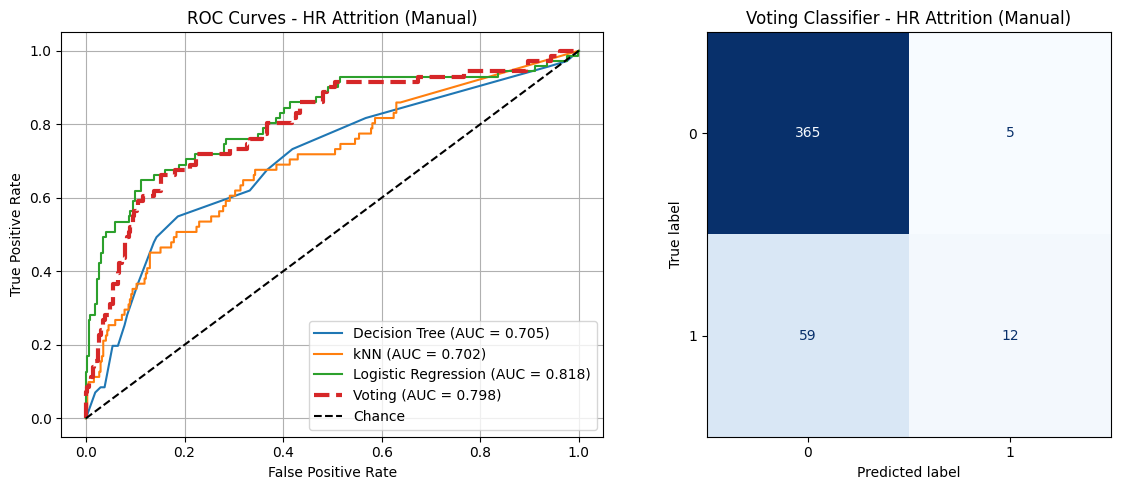


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'feature_selection__k': 4}
Best CV score: 0.7113

--- GridSearchCV for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for kNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'feature_selection__k': 46}
Best CV score: 0.7305

--- GridSearchCV for Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 46}
Best CV score: 0.8328


EVALUATING BUILT-IN MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8163
  Precision: 0.3684
  Recall: 0.1972
  F1-Score: 0.2569
  ROC AUC: 0.7052

kNN:
  Accuracy: 0.8481
  Precision: 0.7000
  Recall: 0.0986
  F1-Score: 0.1728
  ROC AUC: 0.7025

Logistic Regression:
  Accuracy: 0.8798
  Precision: 0.7368
  Recall: 0.3944
  F1-Score: 0.5138
  ROC AUC: 0.8177

--- Built-in Voting Classifier ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

Voting Classifier Performance:
  Accuracy: 0.8435, Precision: 0.5500
  Recall: 0.1549, F1: 0.2418, AUC: 0.7976



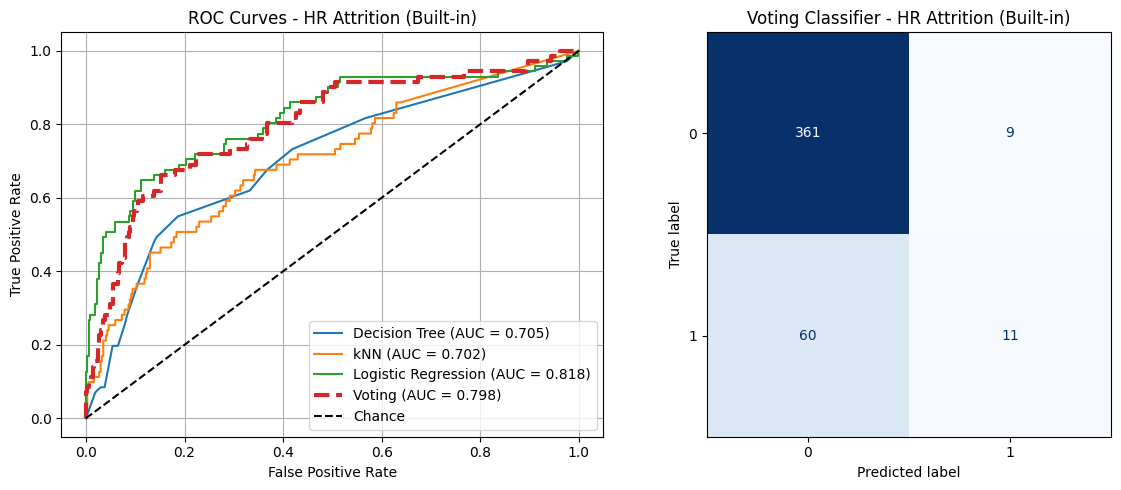


Completed processing for HR Attrition

ALL DATASETS PROCESSED!


In [9]:
# --- Run Pipeline for All Datasets ---
datasets = [
    # (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    # (load_banknote, "Banknote Authentication"),
    # (load_qsar_biodegradation, "QSAR Biodegradation")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        res = run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)